In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib

In [4]:
df = pd.read_csv('Events.csv')

In [5]:
df = df[(df['chi2']!=0)]

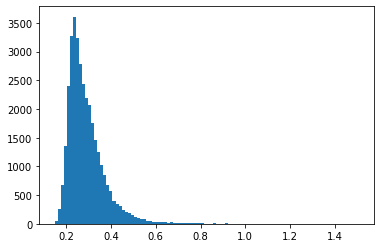

In [6]:
plt.hist(df['chi2'],bins=100)
plt.show()

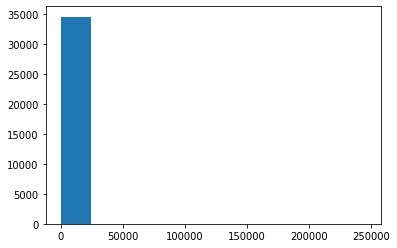

In [7]:
plt.hist(df['sigmat0'])
plt.show()

In [8]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x',
       'Laputop_pos_y'],
      dtype='object')

In [9]:
r = ((df['x'].values-df['ShowerCOG_x'].values)**2.0 + (df['y'].values-df['ShowerCOG_y'].values)**2.0 + (df['z'].values-df['ShowerCOG_z'].values)**2.0)**0.5

In [10]:
for i in range(len(r)):
    if df['ShowerCOG_time'].values[i] < df['t0'].values[i]:
        r[i] = r[i]
    else:
        r[i] = -r[i]

In [11]:
df['r'] = r

In [12]:
c = .299

In [13]:
def get_delta(r,a,b,sigma):
    delta = a * r**2.0 #+ b * (1-np.exp(-(r**2.0)/(2*sigma**2.0)))
    return delta

In [14]:
def get_n(x,y,z):
    x,y,z = np.array([x,y,z])/(x**2.0+y**2.0+z**2.0)**0.5
    return [x,y,z]

In [15]:
def get_t(X,x1,y1,z1,a,b,sigma,xc,yc,zc,tc):
    x,y,z,r = X
    n = get_n(x1,y1,z1)
    x1 = (x-xc)*n[0]
    x2 = (y-yc)*n[1]
    x3 = (z-zc)*n[2] 
    new = x1 + x2 + x3
    t = tc + (1/c)*np.array(new) + get_delta(r,a,b,sigma)
    return t

In [16]:
def get_angular_resolution(x1,y1,z1,x2,y2,z2):
    n1 = np.array(get_n(x1,y1,z1))
    n2 = np.array(get_n(x2,y2,z2))
    if np.dot(n1,n2)>1:
        value = 1
        angular_res = np.arccos(value)*180/np.pi
    else:
        angular_res = np.arccos(np.dot(n1,n2))*180/np.pi
    return angular_res

In [17]:
from scipy.optimize import curve_fit

In [18]:
from functools import partial

In [19]:
events = df['Unnamed: 0'].unique()

In [20]:
def clean(event1):
    doms = []
    strings = []
    chi2 = []
    chargeVEM = []
    remove_index_list = []
    for value in range(len(event1)):
        doms.append(event1['Unnamed: 1'].values[value].split(',')[1])
        strings.append(event1['Unnamed: 1'].values[value].split(',')[0].split('(')[1])
        chi2.append(event1['chi2'].values[value])
        chargeVEM.append(event1['r'].values[value])
    doms = np.array(doms)
    strings = np.array(strings)
    chi2 = np.array(chi2)
    chargeVEM = np.array(chargeVEM)
    
    check = []
    
    for string in np.unique(strings):
        if np.sum(strings==string)==2:
            index_max = np.argmax(chi2[strings==string])
            if index_max == 0:
                check.append(False)
            else:
                check.append(True)
            if check[-1]:
                check.append(False)
            else:
                check.append(True)
        else:
            check.append(True)
            
    for i in range(len(check)):
        cutoff = np.mean(chi2[check])+2*np.mean(chi2[check])/len(chi2[check])
        if (chi2[i]>=cutoff):
            check[i] = False
    
    for i in range(len(check)):
        if not check[i]:
            remove_index_list.append(i)
    return remove_index_list,check

In [21]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x', 'Laputop_pos_y',
       'r'],
      dtype='object')

In [22]:
laputop_zenith = []
laputop_azimuth = []
mc_zenith = []
mc_azimuth = []
angular_resolution = []
for event in events:
    event1 = df.loc[df['Unnamed: 0'] == event]
    laputop_zenith.append(event1['Laputop_dir_zenith'].values[0])
    laputop_azimuth.append(event1['Laputop_dir_azimuth'].values[0])
    mc_zenith.append(event1['zenith'].values[0])
    mc_azimuth.append(event1['azimuth'].values[0])
    angular_resolution.append(event1['angular_resolution'].values[0])

In [23]:
ang_res = []
laputop_res = []
residuals = []
energy = []
zenith = []

def get_fit(event):

    event1 = df.loc[df['Unnamed: 0'] == event]
    #event1 = event1.loc[abs(event1['r'])>50]
    
    energy = event1['energy'].values[0]
    zenith = event1['zenith'].values[0]
    true_zen = event1['zenith'].values[0]
    true_az = event1['azimuth'].values[0]
    
    true_x = -np.sin(true_zen) * np.cos(true_az)
    true_y = -np.sin(true_zen) * np.sin(true_az)
    true_z = -np.cos(true_zen)

    tc = event1['ShowerCOG_time'].values[0]
    xc = event1['ShowerCOG_x'].values[0]
    yc = event1['ShowerCOG_y'].values[0]
    zc = event1['ShowerCOG_z'].values[0]
    zen_shower = event1['ShowerCOG_zen'].values[0]
    az_shower = event1['ShowerCOG_az'].values[0]
    
    first_x = -np.sin(zen_shower) * np.cos(az_shower)
    first_y = -np.sin(zen_shower) * np.sin(az_shower)
    first_z = -np.cos(zen_shower) 
    
    x_o = event1['x'].values
    y_o = event1['y'].values
    z_o = event1['z'].values
    r_o = event1['r'].values
    t0_o = event1['t0'].values
    
    get_t_new = partial(get_t,tc=tc,xc=xc,yc=yc,zc=zc)
    
    check = [True for i in range(len(event1))]
    print(len(check))
    #if len(event1)<20:
    #    remove_index_list = []
    #    check = [True for i in range(len(event1))]
    #else:
    #    remove_index_list,check = clean(event1)
    
    fit_old = curve_fit(get_t_new,(x_o,y_o,z_o,r_o),t0_o,
                    p0=[-0.5,-0.5,-0.5,4.823*10**-4,19.51,83.5],
                    bounds=((-1,-1,-1,0,0,0),(1,1,0,1,200,200)),
                    maxfev=3000)
    
    ang_res_fit_o = get_angular_resolution(fit_old[0][0],fit_old[0][1],fit_old[0][2],true_x,true_y,true_z)
    
    count = 0
    remove_index_list = []

    fit_list = []
    fit_list.append(fit_old)
    
    ang_res_list = []
    ang_res_list.append(ang_res_fit_o)
    
    while True:
        if count == 0:
            check1 = np.copy(check)
        else:
            check1[remove_index] = False

        ang_list_test = []
        fit_check = []
        
        for i in np.array(range(len(check1))):
            check2 = np.copy(check1)
            check2[i] = False
            
            if len(check) > 10:
                if (i in remove_index_list) or (abs(event1['r'].values[i])<np.percentile(abs(event1['r'].values),10)):
                    ang_list_test.append(np.inf)
                    fit_check.append(fit_old)
                    continue
            else:
                if (i in remove_index_list):
                    ang_list_test.append(np.inf)
                    fit_check.append(fit_old)
                    continue
            #if i in remove_index_list:
            #    ang_list_test.append(np.inf)
            #    fit_check.append(fit_old)
            #    continue

            x = event1['x'].values[check2]
            y = event1['y'].values[check2]
            z = event1['z'].values[check2]
            r = event1['r'].values[check2]
            t0 = event1['t0'].values[check2]
    
            get_t_new = partial(get_t,tc=tc,xc=xc,yc=yc,zc=zc)
        
            fit = curve_fit(get_t_new,(x,y,z,r),t0,
                            p0=[-0.5,-0.5,-0.5,4.823*10**-4,19.51,83.5],
                            bounds=((-1,-1,-1,0,0,0),(1,1,0,1,200,200)),
                            maxfev=3000)
            
            ang_res_new = get_angular_resolution(fit[0][0],fit[0][1],fit[0][2],true_x,true_y,true_z)
            ang_list_test.append(ang_res_new)
            fit_check.append(fit)
            
        remove_index = np.argmin(ang_list_test)
        remove_index_list.append(remove_index)

        check1[remove_index]=False
        
        fit_new = fit_check[remove_index]
        fit_list.append(fit_new)
        
       
        ang_res_new = get_angular_resolution(fit_new[0][0],fit_new[0][1],fit_new[0][2],true_x,true_y,true_z)

        ang_res_list.append(ang_res_new)
        
        if (ang_res_new>ang_res_list[-2]):
            #check1[remove_index] = True
            ang_res_final=ang_res_list[-1]
            print(ang_res_list)
            
            lap_az = event1['Laputop_dir_azimuth'].values[0]
            lap_zen = event1['Laputop_dir_zenith'].values[0]
            lapx = -np.sin(lap_zen)*np.cos(lap_az)
            lapy = -np.sin(lap_zen)*np.sin(lap_az)
            lapz = -np.cos(lap_zen)
            laputop = get_angular_resolution(lapx,lapy,lapz,true_x,true_y,true_z)
            break
        count+=1  
        
        
    return event,check1,ang_res_final
        
    

In [24]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x', 'Laputop_pos_y',
       'r'],
      dtype='object')

In [25]:
import time

In [55]:
my_event = 200

In [56]:
our_dict = {}
count = 0
for event in [events[my_event]]:
    if count == 500:
        print(count)
        count = 0
    time1 = time.time()
    event_name,check1,ang_res_final = get_fit(event)
    our_dict[event_name] = {}
    our_dict[event_name]['check'] = check1
    our_dict[event_name]['ang_res_final'] = ang_res_final
    time2 = time.time()
    count+=1

72
[1.660938255451031, 0.5492542574348156, 0.3510563764032385, 0.08117461083856736, 0.010325053282200108, 0.006208115489470879, 0.0029782905806766177, 0.0018559173555772151, 0.004178849252514631]


In [57]:
our_dict

{'event_200': {'check': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True, False,  True,  True, False,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True, False,  True,  True,  True, False, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True]),
  'ang_res_final': 0.004178849252514631}}

In [58]:
event = df[df['Unnamed: 0']=='event_%s'%(my_event)]

In [59]:
import seaborn as sns

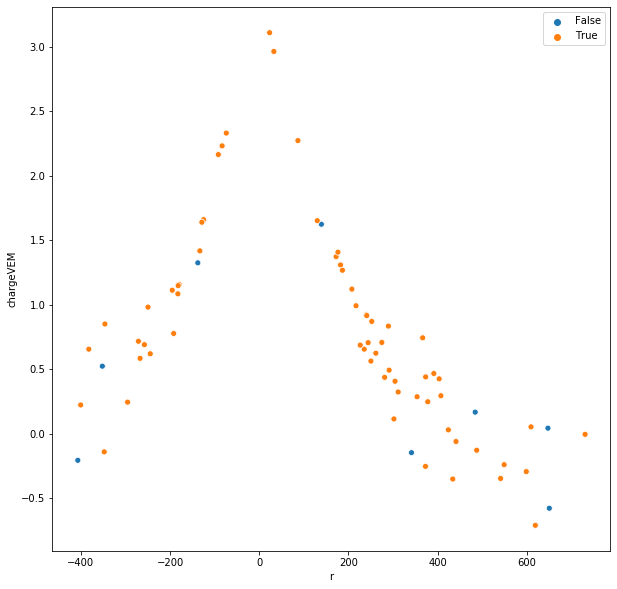

In [60]:
plt.figure(figsize=(10,10))
sns.scatterplot(event['r'],np.log10(event['chargeVEM']),hue=our_dict['event_%s'%(my_event)]['check'])
#plt.scatter(0,event['ShowerCOG_time'].values[0],color='r')
plt.show()

In [61]:
np.percentile(abs(event['r'].values),30)

210.40746193088665

In [182]:
event.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x', 'Laputop_pos_y',
       'r'],
      dtype='object')